In [1]:
from __future__ import annotations
import itertools
import math
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression

In [6]:
male_data = pd.read_excel(r'男胎.xlsx')

In [7]:
male_data.isnull().sum()

序号                0
孕妇代码              0
年龄                0
身高                0
体重                0
末次月经             12
IVF妊娠             0
检测日期              0
检测抽血次数            0
检测孕周              0
孕妇BMI             0
原始读段数             0
在参考基因组上比对的比例      0
重复读段的比例           0
唯一比对的读段数          0
GC含量              0
13号染色体的Z值         0
18号染色体的Z值         0
21号染色体的Z值         0
X染色体的Z值           0
Y染色体的Z值           0
Y染色体浓度            0
X染色体浓度            0
13号染色体的GC含量       0
18号染色体的GC含量       0
21号染色体的GC含量       0
被过滤掉读段数的比例        0
染色体的非整倍体        956
怀孕次数              0
生产次数              0
胎儿是否健康            0
dtype: int64

In [8]:
male_data['末次月经'] = pd.to_datetime(male_data['末次月经'], errors='coerce')

# 方法 1：使用最频繁的日期填补
most_frequent_date = male_data['末次月经'].mode()[0]  # 找到最常见的日期
male_data['末次月经'] = male_data['末次月经'].fillna(most_frequent_date)
print(male_data['末次月经'].isnull().sum())

0


In [9]:
import re

def extract_week(x):

    if '+' in x:
   
        week_number = int(re.findall(r'\d+', x)[0])  # 提取 'w' 前面的数字
        extra_days = int(re.findall(r'\d+', x.split('+')[1])[0])  # 提取 '+' 后面的数字
        return week_number + extra_days / 7
    else:
 
        return int(re.findall(r'\d+', x)[0])


male_data['检测孕周'] = male_data['检测孕周'].apply(extract_week)



In [10]:
male_data

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,Y染色体浓度,X染色体浓度,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康
0,1,A001,31,160.0,72.00,2023-02-01,自然受孕,20230429,1,11.857143,...,0.025936,0.038061,0.377069,0.389803,0.399399,0.027484,NaN,1,0,是
1,2,A001,31,160.0,73.00,2023-02-01,自然受孕,20230531,2,15.857143,...,0.034887,0.059572,0.371542,0.384771,0.391706,0.019617,NaN,1,0,是
2,3,A001,31,160.0,73.00,2023-02-01,自然受孕,20230625,3,20.142857,...,0.066171,0.075995,0.377449,0.390582,0.399480,0.022312,NaN,1,0,是
3,4,A001,31,160.0,74.00,2023-02-01,自然受孕,20230716,4,22.857143,...,0.061192,0.052305,0.375613,0.389251,0.397212,0.023280,NaN,1,0,是
4,5,A002,32,149.0,74.00,2023-11-09,自然受孕,20240219,1,13.857143,...,0.059230,0.059708,0.380260,0.393618,0.404868,0.024212,NaN,2,1,否
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,1078,A266,30,159.0,83.35,2022-12-29,自然受孕,2023-05-02 00:00:00,4,17.714286,...,0.099052,0.056686,0.376861,0.389914,0.397090,0.017951,T18,1,0,是
1078,1079,A267,28,155.0,73.76,2023-02-25,自然受孕,2023-05-17 00:00:00,1,11.571429,...,0.098706,0.023663,0.377597,0.387901,0.404293,0.022549,T21,1,0,是
1079,1080,A267,28,155.0,74.06,2023-02-25,自然受孕,2023-05-24 00:00:00,2,12.571429,...,0.102088,0.080264,0.379041,0.391748,0.400433,0.021330,NaN,1,0,是
1080,1081,A267,28,155.0,74.74,2023-02-25,自然受孕,2023-05-31 00:00:00,3,13.571429,...,0.109855,0.074050,0.379107,0.388544,0.401030,0.022013,NaN,1,0,是


In [11]:
def estimate_T_for_one(person_df: pd.DataFrame,
                       threshold: float = 0.04,
                       delta: float = 0.003,
                       enforce_monotonic: bool = True,
                       return_curve: bool = False) -> Tuple[Optional[float], bool, Optional[np.ndarray], Optional[np.ndarray]]:
    """
    对同一受试者的序列（列：week, y），按孕周排序，做平滑并求“首次达标周”T。
    返回：
      T (float 或 None)  —— 若始终未达标，返回 None（视作右删失）
      censored (bool)    —— True 表示右删失（至末次观测仍未≥阈值）
      weeks_sorted (np.ndarray) —— （可选）排序后的周
      y_smooth (np.ndarray)     —— （可选）平滑/单调化后的 y
    """
    sdf = person_df.sort_values("week")
    w = sdf["week"].values
    y = sdf["y"].values

    if len(w) == 0:
        return None, True, None, None

    # 单调平滑：Y 应随孕周上升，用等距下的各向同性单调回归近似
    if enforce_monotonic and len(w) >= 2:
        # 为避免 x 的重复值问题，稍作抖动（或预先 groupby week 取均值，已做）
        iso = IsotonicRegression(increasing=True, out_of_bounds="clip")
        y_hat = iso.fit_transform(w, y)
    else:
        y_hat = y.copy()

    thr = threshold + delta

    # 若最后一点仍未达标，则视为右删失
    if y_hat[-1] < thr:
        return None, True, w, y_hat

    # 找最早交叉点：线性插值求精确周
    for i in range(1, len(w)):
        if y_hat[i-1] < thr <= y_hat[i]:
            # 线性插值 t = w[i-1] + (thr - y1)*(w2-w1)/(y2-y1)
            y1, y2 = y_hat[i-1], y_hat[i]
            x1, x2 = w[i-1], w[i]
            if y2 == y1:
                t_cross = x2
            else:
                t_cross = x1 + (thr - y1) * (x2 - x1) / (y2 - y1)
            return float(t_cross), False, w, y_hat

    # 理论上走不到这里；兜底
    return float(w[-1]), False, w, y_hat

In [12]:
def build_T_dataset(df: pd.DataFrame,
                    threshold: float = 0.04,
                    delta: float = 0.003) -> pd.DataFrame:
    """为每个受试者计算 (T, censored, bmi)。bmi 取个体中位数。"""
    records = []
    for pid, g in df.groupby("id"):
        T, cens, _, _ = estimate_T_for_one(g[["week", "y"]], threshold=threshold, delta=delta)
        bmi_val = float(g["bmi"].median()) if len(g) else np.nan
        records.append({"id": pid, "T": T, "censored": cens, "bmi": bmi_val})
    out = pd.DataFrame(records)
    out = out.dropna(subset=["bmi"])  # T 可能是 None（右删失），bmi 必须有
    return out

In [13]:
def km_survival(times: np.ndarray, events: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    简单 Kaplan-Meier：
    输入：times (事件或删失时间)，events(1=事件发生；0=右删失)
    输出：unique_event_times, S(t) 在这些事件时刻的取值（阶梯函数右极限）
    备注：用于估 P(T>t)。
    """
    # 仅在事件时刻更新 S
    df = pd.DataFrame({"t": times, "e": events}).sort_values(["t", "e"], ascending=[True, False])
    uniq_event_times = np.sort(df.loc[df["e"] == 1, "t"].unique())
    S = 1.0
    S_list = []
    at_risk_n = len(df)
    idx = 0
    # 迭代每个事件时刻，计算当时的在险人数和事件数
    for u in uniq_event_times:
        # 在时刻 u 之前离开的（删失/事件 <u）已在风险集中剔除；这里简化处理：逐时刻重算在险人数
        at_risk_n = ((df["t"] >= u)).sum()
        d_u = ((df["t"] == u) & (df["e"] == 1)).sum()
        if at_risk_n > 0:
            S *= (1.0 - d_u / at_risk_n)
        S_list.append(S)
    return uniq_event_times, np.array(S_list, dtype=float)


def S_of_t(t: float, event_times: np.ndarray, S_vals: np.ndarray) -> float:
    """返回任意 t 的 S(t)（右连续阶梯）：取 t 所在的最后一个事件时刻的 S。"""
    if len(event_times) == 0:
        return 1.0
    idx = np.searchsorted(event_times, t, side="right") - 1
    if idx < 0:
        return 1.0
    return float(S_vals[idx])


def expected_late_term(t: float, W_late: float,
                       event_times: np.ndarray,
                       S_vals: np.ndarray) -> float:
    """
    计算 E[(t - T)_+ * 1{T>W_late}] ≈ sum_{u in (W_late, t]} (t - u) * dF(u)，
    其中 dF(u) ≈ -ΔS(u) 在事件时刻的跳跃量（来自 KM 曲线）。
    """
    if len(event_times) == 0 or t <= W_late:
        return 0.0
    # 计算跳跃量 dF(u) = -ΔS(u)
    S_prev = 1.0
    val = 0.0
    for u, S_u in zip(event_times, S_vals):
        if u <= W_late:
            S_prev = S_u
            continue
        if u > t:
            break
        dF = max(0.0, S_prev - S_u)
        val += (t - float(u)) * dF
        S_prev = S_u
    return float(val)


@dataclass
class CostParams:
    c_early: float = 1.0
    c_late: float = 1.0
    W_late: float = 12.0   # 晚发现开始计惩罚的阈值周（示例）


def compute_bin_cost(times: np.ndarray, events: np.ndarray,
                     t_grid: np.ndarray, params: CostParams) -> Tuple[float, float, Dict]:
    """
    给定一个 BMI 分组样本(的 T, event)，在 t_grid 上找使 EC(t) 最小的 t*。
    返回：(最小成本, t*, 附加信息dict)
    附加信息包含：P_early(t*), P_late(t*), S曲线节点等。
    """
    # KM 生存曲线
    ev_times, S_vals = km_survival(times, events)

    best_cost = math.inf
    best_t = None
    best_info = {}

    for t in t_grid:
        P_early = S_of_t(t, ev_times, S_vals)  # P(T>t)
        late_term = expected_late_term(t, params.W_late, ev_times, S_vals)
        cost = params.c_early * P_early + params.c_late * late_term
        if cost < best_cost:
            # 粗略估计晚发现概率：P(W_late < T ≤ t) ≈ F(t) - F(W_late)
            S_t = S_of_t(t, ev_times, S_vals)
            S_w = S_of_t(params.W_late, ev_times, S_vals)
            P_late = max(0.0, (1 - S_t) - (1 - S_w))
            best_cost = cost
            best_t = float(t)
            best_info = {
                "P_early": float(P_early),
                "P_late": float(P_late),
                "ev_times": ev_times,
                "S_vals": S_vals,
            }
    return best_cost, best_t, best_info


In [14]:
def precompute_bin_costs(dfT: pd.DataFrame,
                         candidate_edges: np.ndarray,
                         t_grid: np.ndarray,
                         params: CostParams,
                         min_bin_size: int = 30) -> Tuple[np.ndarray, np.ndarray, List[List[Dict]]]:
    """
    对所有候选 BMI 区间 [edge[i], edge[j]) 预先计算：
      - cost[i,j]：该区间的最小期望成本
      - best_t[i,j]：对应的最优检测周
      - extras[i][j]：字典，含 P_early, P_late 等
    不满足最小样本量的区间记为 +inf。
    """
    M = len(candidate_edges)
    cost = np.full((M, M), np.inf, dtype=float)
    best_t = np.full((M, M), np.nan, dtype=float)
    extras: List[List[Dict]] = [[{} for _ in range(M)] for __ in range(M)]

    for i in range(M - 1):
        for j in range(i + 1, M):
            lo, hi = candidate_edges[i], candidate_edges[j]
            sub = dfT[(dfT["bmi"] >= lo) & (dfT["bmi"] < hi)]
            if len(sub) < min_bin_size:
                continue
            times = sub["T"].fillna(sub["T"].max() + 1e-6).values  # 对None已在构建阶段保留为空；这里用 fillna 仅防极端
            events = (~sub["censored"]).astype(int).values
            c, t_star, info = compute_bin_cost(times, events, t_grid, params)
            cost[i, j] = c
            best_t[i, j] = t_star
            extras[i][j] = info | {"n": int(len(sub)), "bmi_range": (float(lo), float(hi))}
    return cost, best_t, extras


def optimal_binning_dp(candidate_edges: np.ndarray,
                        cost_mat: np.ndarray,
                        K: int) -> Tuple[List[Tuple[float, float]], List[Tuple[int, int]]]:
    """
    动态规划：在候选边界上选 K 个分箱（K 个区间），使区间成本和最小。
    返回：
      bins_ranges: 每个箱的 (lo, hi)
      idx_pairs: 每个箱对应的 (i, j) 索引区间
    """
    M = len(candidate_edges)
    dp = np.full((K + 1, M), np.inf)
    prev = [[-1] * M for _ in range(K + 1)]

    dp[0, 0] = 0.0

    for k in range(1, K + 1):
        for j in range(1, M):
            # 枚举上一个断点 i
            best_val = np.inf
            best_i = -1
            for i in range(0, j):
                c = cost_mat[i, j]
                if not np.isfinite(c):
                    continue
                if np.isfinite(dp[k - 1, i]):
                    v = dp[k - 1, i] + c
                    if v < best_val:
                        best_val = v
                        best_i = i
            dp[k, j] = best_val
            prev[k][j] = best_i

    # 终点在 M-1（必须用到最右边界）
    if not np.isfinite(dp[K, M - 1]):
        raise RuntimeError("无法在给定候选边界与样本量约束下找到可行的 K 组切分；请降低 K 或放宽 min_bin_size。")

    # 回溯区间
    idx_pairs: List[Tuple[int, int]] = []
    j = M - 1
    for k in range(K, 0, -1):
        i = prev[k][j]
        if i < 0:
            raise RuntimeError("回溯失败，请检查 cost 矩阵是否连通。")
        idx_pairs.append((i, j))
        j = i
    idx_pairs.reverse()

    bins_ranges = [(float(candidate_edges[i]), float(candidate_edges[j])) for (i, j) in idx_pairs]
    return bins_ranges, idx_pairs

In [15]:
def run_pipeline(cfg: Dict,
                 threshold: float = 0.04,
                 delta: float = 0.003,
                 K: int = 4,
                 min_week: float = 9.0,
                 max_week: float = 16.0,
                 week_step: float = 0.25,
                 min_bin_size: int = 30,
                 cost_params: Optional[CostParams] = None,
                 candidate_mode: str = "quantile",
                 n_edges: int = 21,
                 verbose: bool = True) -> Dict:
    """
    运行完整管线：
     1) 读数-清洗；2) 估计 T；3) 预计算每个 BMI 区间成本；4) DP 找最优分箱；5) 汇报结果。
    参数：
      - K: BMI 分组数量
      - delta: 阈值缓冲（默认 0.003 = 0.3个百分点）
      - candidate_mode: 候选边界生成方式（'quantile' 或 'unique'）
      - n_edges: 若为 quantile，则在 [min,max] 均匀分位生成 n_edges 个边界点
    返回：包含关键中间结果与最终方案的字典。
    """
    if cost_params is None:
        cost_params = CostParams()

    if verbose:
        print("[1/5] 读取与清洗数据…")
    df = load_and_prepare_data(cfg)

    if verbose:
        print("[2/5] 估计各个体的首次达标周 T（带阈值缓冲）…")
    dfT = build_T_dataset(df, threshold=threshold, delta=delta)

    # 候选 BMI 边界
    if candidate_mode == "quantile":
        qs = np.linspace(0, 1, n_edges)
        edges = np.quantile(dfT["bmi"].values, qs)
        edges[0] = float(dfT["bmi"].min())
        edges[-1] = float(dfT["bmi"].max()) + 1e-9  # 右开区间保障覆盖
        candidate_edges = np.unique(edges)
    else:
        vals = np.sort(dfT["bmi"].values)
        candidate_edges = np.r_[vals[::max(1, len(vals)//(n_edges-1))], vals[-1] + 1e-9]

    # t 的离散搜索网格
    t_grid = np.arange(min_week, max_week + 1e-9, week_step)

    if verbose:
        print("[3/5] 预计算所有候选 BMI 区间的最优 t* 与成本…")
    cost_mat, best_t_mat, extras = precompute_bin_costs(
        dfT, candidate_edges, t_grid, cost_params, min_bin_size=min_bin_size
    )

    if verbose:
        print("[4/5] 动态规划搜索 K 组的全局最优切分…")
    bin_ranges, idx_pairs = optimal_binning_dp(candidate_edges, cost_mat, K)

    # 汇总每组信息
    groups = []
    total_cost = 0.0
    for (i, j), (lo, hi) in zip(idx_pairs, bin_ranges):
        c = cost_mat[i, j]
        t_star = best_t_mat[i, j]
        info = extras[i][j]
        groups.append({
            "BMI_range": (lo, hi),
            "t_star": float(t_star),
            "expected_cost": float(c),
            "P_early": float(info.get("P_early", np.nan)),
            "P_late": float(info.get("P_late", np.nan)),
            "n": int(info.get("n", 0)),
        })
        total_cost += float(c)

    result = {
        "config": cfg,
        "threshold": threshold,
        "delta": delta,
        "K": K,
        "min_week": min_week,
        "max_week": max_week,
        "week_step": week_step,
        "min_bin_size": min_bin_size,
        "cost_params": cost_params,
        "candidate_edges": candidate_edges,
        "t_grid": t_grid,
        "groups": groups,
        "total_expected_cost": total_cost,
        "dfT": dfT,
    }

    if verbose:
        print("[5/5] 完成。")
        print("—— 推荐方案 ——")
        for g in groups:
            lo, hi = g["BMI_range"]
            print(f"BMI∈[{lo:.2f}, {hi:.2f}) → 推荐检测周 t* = {g['t_star']:.2f}（样本 n={g['n']}）\n"
                  f"    早到概率≈P(T>t*)={g['P_early']:.3f}，晚发现概率≈{g['P_late']:.3f}，期望成本={g['expected_cost']:.4f}")
        print(f"总期望成本 = {total_cost:.4f}")

    return result

In [16]:
def sensitivity_grid(cfg: Dict,
                      K_list: List[int] = (3, 4, 5),
                      delta_list: List[float] = (0.002, 0.003, 0.005),
                      c_early_list: List[float] = (1.0, 1.0, 1.0),
                      c_late_list: List[float] = (0.5, 1.0, 2.0),
                      W_late_list: List[float] = (11.0, 12.0, 13.0),
                      **kwargs) -> pd.DataFrame:
    """网格扫描关键参数，比较总期望成本与方案稳定性。"""
    rows = []
    for K in K_list:
        for delta in delta_list:
            for ce in c_early_list:
                for cl in c_late_list:
                    for Wl in W_late_list:
                        params = CostParams(c_early=ce, c_late=cl, W_late=Wl)
                        try:
                            res = run_pipeline(cfg, K=K, delta=delta, cost_params=params, verbose=False, **kwargs)
                            rows.append({
                                "K": K,
                                "delta": delta,
                                "c_early": ce,
                                "c_late": cl,
                                "W_late": Wl,
                                "total_cost": res["total_expected_cost"],
                                "groups": res["groups"],
                            })
                        except Exception as e:
                            rows.append({
                                "K": K, "delta": delta, "c_early": ce, "c_late": cl, "W_late": Wl,
                                "total_cost": np.nan, "groups": str(e)
                            })
    return pd.DataFrame(rows)


In [19]:
if __name__ == "__main__":
    # 1) 先把 CONFIG 里的列名改成你实际的数据列名，然后再运行。
    # 2) 设定关键参数：
    cfg = CONFIG.copy()

    params = CostParams(
        c_early=1.0,   # 过早（未达标/复检）的单位代价
        c_late=1.5,    # 过晚（超过 W_late 后）的单位代价
        W_late=12.0    # 晚发现起算周
    )

    # 运行主流程（K=4 组；t 在 9~16 周、步长 0.25 周 里选最优）
    result = run_pipeline(
        cfg,
        threshold=0.04,
        delta=0.003,
        K=4,
        min_week=9.0,
        max_week=16.0,
        week_step=0.25,
        min_bin_size=30,
        cost_params=params,
        candidate_mode="quantile",
        n_edges=21,
        verbose=True,
    )

    # 如需做灵敏度：
    # grid = sensitivity_grid(cfg, K_list=[3,4,5], delta_list=[0.002,0.003,0.005],
    #                         c_early_list=[1.0], c_late_list=[0.5,1.0,2.0], W_late_list=[11.0,12.0,13.0],
    #                         threshold=0.04, min_week=9.0, max_week=16.0, week_step=0.25, min_bin_size=30,
    #                         candidate_mode="quantile", n_edges=21)
    # print(grid.sort_values("total_cost").head(10))



NameError: name 'CONFIG' is not defined

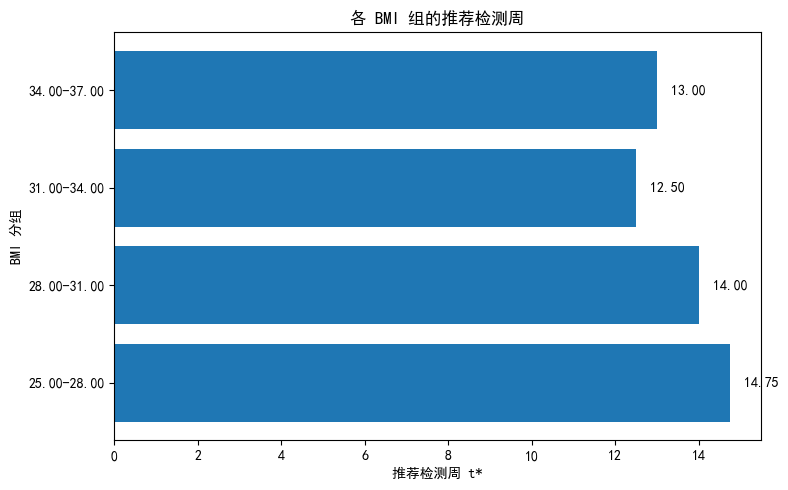

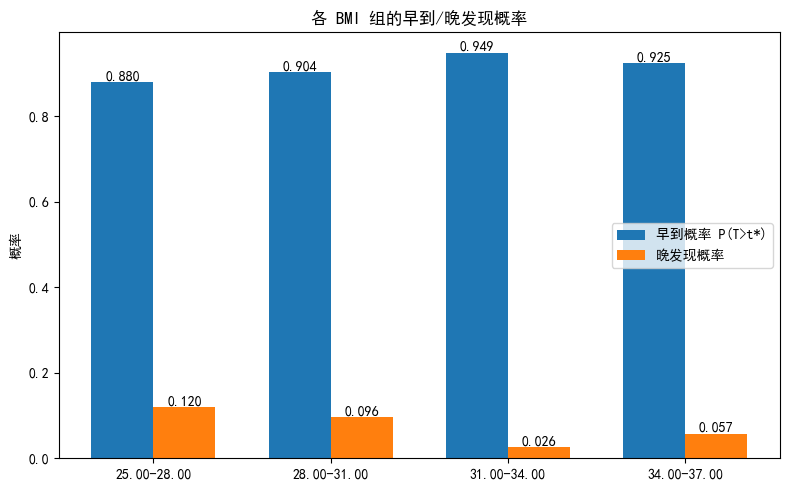

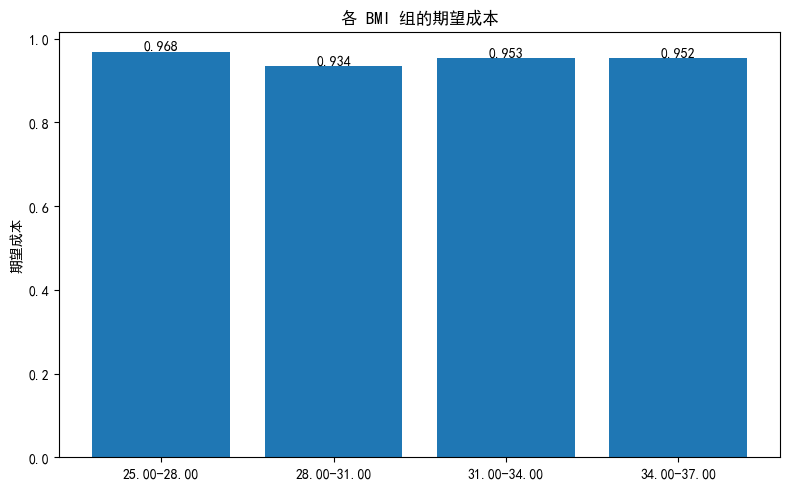

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 优先使用 macOS 的 PingFang SC；否则回退到常见中文字体
plt.rcParams['font.sans-serif'] = ['PingFang SC','Heiti SC','Heiti TC','Arial Unicode MS','SimHei','Noto Sans CJK SC']
plt.rcParams['axes.unicode_minus'] = False

# ====== 1) 准备数据 ======
USE_RESULT = False  # 如果你环境里有 run_pipeline 的返回值 result，就改成 True

if USE_RESULT:
    # A) 直接用 run_pipeline 的返回值
    # 假设你已经运行过：result = run_pipeline(...)
    groups = []
    for g in result["groups"]:
        lo, hi = g["BMI_range"]
        groups.append({
            "BMI_range": (lo, hi),
            "t_star": g["t_star"],
            "P_early": g["P_early"],
            "P_late": g["P_late"],
            "expected_cost": g["expected_cost"],
        })
else:
    # B) 用你贴出来的控制台结果手动构造
    groups = [
        {"BMI_range": (25, 28), "t_star": 14.75, "P_early": 0.880, "P_late": 0.120, "expected_cost": 0.9682},
        {"BMI_range": (28, 31), "t_star": 14.00, "P_early": 0.904, "P_late": 0.096, "expected_cost": 0.9343},
        {"BMI_range": (31, 34), "t_star": 12.50, "P_early": 0.949, "P_late": 0.026, "expected_cost": 0.9530},
        {"BMI_range": (34, 37), "t_star": 13.00, "P_early": 0.925, "P_late": 0.057, "expected_cost": 0.9524},
    ]

df_groups = pd.DataFrame(groups)
labels = [f"{lo:.2f}-{hi:.2f}" for lo, hi in df_groups["BMI_range"]]

# ====== 2) 图一：各 BMI 组的推荐检测周 t* ======
plt.figure(figsize=(8, 5))
plt.barh(labels, df_groups["t_star"])
plt.xlabel("推荐检测周 t*")
plt.ylabel("BMI 分组")
plt.title("各 BMI 组的推荐检测周")
for y, v in enumerate(df_groups["t_star"]):
    plt.text(v, y, f"  {v:.2f}", va="center")  # 条形末尾标注
plt.tight_layout()
# plt.savefig("fig_tstar_by_bmi.png", dpi=300)  # 如需保存，取消注释
plt.show()

# ====== 3) 图二：各组早到概率 & 晚发现概率 ======
x = np.arange(len(df_groups))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, df_groups["P_early"], width, label="早到概率 P(T>t*)")
rects2 = ax.bar(x + width/2, df_groups["P_late"],  width, label="晚发现概率")

ax.set_ylabel("概率")
ax.set_title("各 BMI 组的早到/晚发现概率")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 在柱顶标注数值
for r in rects1:
    h = r.get_height()
    ax.text(r.get_x() + r.get_width()/2, h, f"{h:.3f}", ha="center", va="bottom")
for r in rects2:
    h = r.get_height()
    ax.text(r.get_x() + r.get_width()/2, h, f"{h:.3f}", ha="center", va="bottom")

plt.tight_layout()
# plt.savefig("fig_probs_by_bmi.png", dpi=300)
plt.show()

# ====== 4) 图三：各组期望成本 ======
plt.figure(figsize=(8, 5))
plt.bar(labels, df_groups["expected_cost"])
plt.ylabel("期望成本")
plt.title("各 BMI 组的期望成本")
for i, v in enumerate(df_groups["expected_cost"]):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
plt.tight_layout()
# plt.savefig("fig_cost_by_bmi.png", dpi=300)
plt.show()